In [1]:
import os, sys
import datetime
from datetime import datetime, date, timedelta
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
from scipy import sparse
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pingouin as pg
import spacy, nltk
from konlpy.tag import Okt

c:\Users\admin\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [54]:
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer

In [84]:
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, RFE, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR

In [4]:
data_df = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'), header=None, index_col=False, 
names = ['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
data = data_df.loc[:, ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income']]
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [5]:
pd.concat([data.dtypes, data.nunique()], axis=1)

,0,1
age,int64,73
workclass,object,9
education,object,16
gender,object,2
hours-per-week,int64,94
occupation,object,15
income,object,2


In [6]:
# dtypes에서 확인할 때 object일 경우에는 자동으로 변환
# columns 파라미터 추가로 변환하고 싶은 열 설정 가능
data_dummies = pd.get_dummies(data)
list(data.columns), list(data_dummies.columns)

(['age',
  'workclass',
  'education',
  'gender',
  'hours-per-week',
  'occupation',
  'income'],
 ['age',
  'hours-per-week',
  'workclass_ ?',
  'workclass_ Federal-gov',
  'workclass_ Local-gov',
  'workclass_ Never-worked',
  'workclass_ Private',
  'workclass_ Self-emp-inc',
  'workclass_ Self-emp-not-inc',
  'workclass_ State-gov',
  'workclass_ Without-pay',
  'education_ 10th',
  'education_ 11th',
  'education_ 12th',
  'education_ 1st-4th',
  'education_ 5th-6th',
  'education_ 7th-8th',
  'education_ 9th',
  'education_ Assoc-acdm',
  'education_ Assoc-voc',
  'education_ Bachelors',
  'education_ Doctorate',
  'education_ HS-grad',
  'education_ Masters',
  'education_ Preschool',
  'education_ Prof-school',
  'education_ Some-college',
  'gender_ Female',
  'gender_ Male',
  'occupation_ ?',
  'occupation_ Adm-clerical',
  'occupation_ Armed-Forces',
  'occupation_ Craft-repair',
  'occupation_ Exec-managerial',
  'occupation_ Farming-fishing',
  'occupation_ Handlers-cl

In [7]:
X = data_dummies.iloc[:, :-2]
y = data.iloc[:, -1].replace({' <=50K':0, ' >50K':1})
X.shape, y.shape

((32561, 44), (32561,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
logreg = LogisticRegression(C=100, max_iter=3000).fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8138001638001638, 0.8086230192851002)

In [10]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0, n_jobs=-1).fit(X_train, y_train)
rf_clf.score(X_train, y_train), rf_clf.score(X_test, y_test)

(0.8620393120393121, 0.8141505957499079)

In [11]:
ct = ColumnTransformer(
    [('scaling', StandardScaler(), ['age', 'hours-per-week']),
    ('onehot', OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])]
)

In [12]:
data_features = data.drop('income', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_features, np.where(data['income'] == ' >50K', 1, 0), random_state=0)

In [13]:
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_train_trans.shape

(24420, 44)

In [14]:
logreg = LogisticRegression(C=10, max_iter=1000).fit(X_train_trans, y_train)
logreg.score(X_train_trans, y_train), logreg.score(X_test_trans, y_test)

(0.8136773136773137, 0.808991524382754)

In [15]:
ct.named_transformers_

{'scaling': StandardScaler(), 'onehot': OneHotEncoder(sparse=False)}

In [16]:
ct = make_column_transformer(
    (StandardScaler(), ['age', 'hours-per-week']),
    (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])
)

In [17]:
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)
X_train_trans.shape

(24420, 44)

In [18]:
logreg = LogisticRegression(C=10, max_iter=1000).fit(X_train_trans, y_train)
logreg.score(X_train_trans, y_train), logreg.score(X_test_trans, y_test)

(0.8136773136773137, 0.808991524382754)

In [19]:
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

In [20]:
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
lr_reg = LinearRegression().fit(X, y)

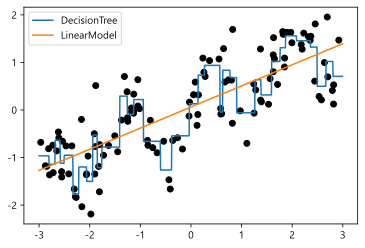

In [21]:
plt.plot(line, dt_reg.predict(line), label='DecisionTree')
plt.plot(line, lr_reg.predict(line), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [22]:
# strategy는 'uniform'(pd.cut), 'quantile'(pd.qcut), 'kmeans' 존재 → default='quantile'
kb = KBinsDiscretizer(n_bins=10, strategy='uniform').fit(X)
kb.bin_edges_

array([array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
              -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
               2.92132162])                                                   ],
      dtype=object)

In [23]:
X_binned = kb.transform(X)
X[:10], X_binned.toarray()[:10]

(array([[-0.75275929],
        [ 2.70428584],
        [ 1.39196365],
        [ 0.59195091],
        [-2.06388816],
        [-2.06403288],
        [-2.65149833],
        [ 2.19705687],
        [ 0.60669007],
        [ 1.24843547]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

In [24]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense').fit(X)
X_binned = kb.transform(X)
X_binned[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
line_binned = kb.transform(line)
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_binned, y)
lr_reg = LinearRegression().fit(X_binned, y)

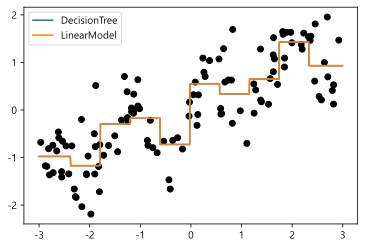

In [26]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_binned), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_binned), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [27]:
X_combined = np.hstack([X, X_binned])
line_combined = np.hstack([line, line_binned])
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_combined, y)
lr_reg = LinearRegression().fit(X_combined, y)

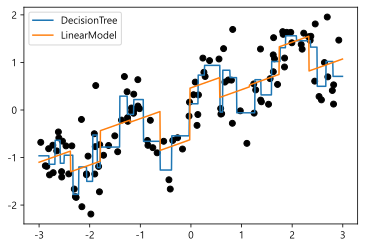

In [28]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_combined), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_combined), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [29]:
X_product = np.hstack([X * X_binned, X_binned])
line_product = np.hstack([line * line_binned, line_binned])
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_product, y)
lr_reg = LinearRegression().fit(X_product, y)

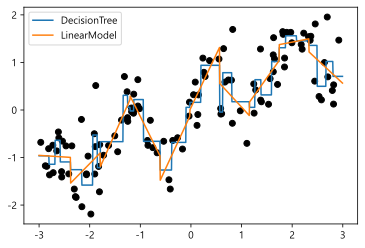

In [30]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_product), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_product), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [31]:
poly = PolynomialFeatures(degree=10, include_bias=True).fit(X)
X_poly = poly.transform(X)
X_poly, poly.get_feature_names_out()

(array([[ 1.00000000e+00, -7.52759287e-01,  5.66646544e-01, ...,
          1.03097700e-01, -7.76077513e-02,  5.84199555e-02],
        [ 1.00000000e+00,  2.70428584e+00,  7.31316190e+00, ...,
          2.86036036e+03,  7.73523202e+03,  2.09182784e+04],
        [ 1.00000000e+00,  1.39196365e+00,  1.93756281e+00, ...,
          1.40936394e+01,  1.96178338e+01,  2.73073115e+01],
        ...,
        [ 1.00000000e+00, -1.88057965e+00,  3.53657981e+00, ...,
          1.56434973e+02, -2.94188426e+02,  5.53244767e+02],
        [ 1.00000000e+00,  2.35535399e+00,  5.54769242e+00, ...,
          9.47217033e+02,  2.23103142e+03,  5.25486876e+03],
        [ 1.00000000e+00,  2.36053451e-01,  5.57212320e-02, ...,
          9.64012886e-06,  2.27558569e-06,  5.37159857e-07]]),
 array(['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8',
        'x0^9', 'x0^10'], dtype=object))

In [32]:
X[:5].round(3), X_poly[:5].round(3)

(array([[-0.753],
        [ 2.704],
        [ 1.392],
        [ 0.592],
        [-2.064]]),
 array([[ 1.0000000e+00, -7.5300000e-01,  5.6700000e-01, -4.2700000e-01,
          3.2100000e-01, -2.4200000e-01,  1.8200000e-01, -1.3700000e-01,
          1.0300000e-01, -7.8000000e-02,  5.8000000e-02],
        [ 1.0000000e+00,  2.7040000e+00,  7.3130000e+00,  1.9777000e+01,
          5.3482000e+01,  1.4463200e+02,  3.9112500e+02,  1.0577140e+03,
          2.8603600e+03,  7.7352320e+03,  2.0918278e+04],
        [ 1.0000000e+00,  1.3920000e+00,  1.9380000e+00,  2.6970000e+00,
          3.7540000e+00,  5.2260000e+00,  7.2740000e+00,  1.0125000e+01,
          1.4094000e+01,  1.9618000e+01,  2.7307000e+01],
        [ 1.0000000e+00,  5.9200000e-01,  3.5000000e-01,  2.0700000e-01,
          1.2300000e-01,  7.3000000e-02,  4.3000000e-02,  2.5000000e-02,
          1.5000000e-02,  9.0000000e-03,  5.0000000e-03],
        [ 1.0000000e+00, -2.0640000e+00,  4.2600000e+00, -8.7910000e+00,
          1.8144000

In [33]:
X_poly
line_poly = poly.transform(line)
dt_reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_poly, y)
lr_reg = LinearRegression().fit(X_poly, y)

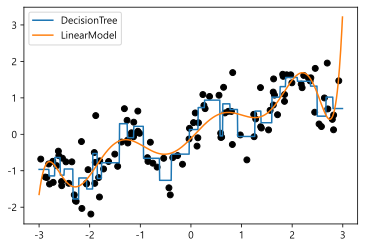

In [34]:
# 선형모델은 유연해졌지만 결정트리는 덜 유연 → 트리모델은 구간화가 득이 되지 않음
plt.plot(line, dt_reg.predict(line_poly), label='DecisionTree')
plt.plot(line, lr_reg.predict(line_poly), label='LinearModel')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

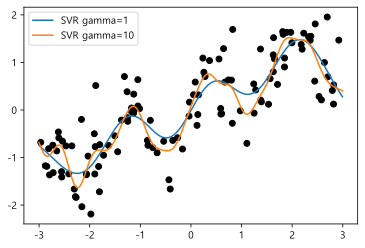

In [35]:
for gamma in [1, 10]:
    svm_reg = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svm_reg.predict(line), label=f'SVR gamma={gamma}')
plt.scatter(X[:, 0], y, c='black')
plt.legend()
plt.show()

In [36]:
boston = load_boston()

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [37]:
X_train, X_test, y_train, y_test = train_test_split(boston['data'], boston['target'], random_state=0)

In [38]:
scaler = MinMaxScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [39]:
poly = PolynomialFeatures(degree=2, interaction_only=True).fit(X_train_sc)
X_train_poly = poly.transform(X_train_sc)
X_test_poly = poly.transform(X_test_sc)
X_train.shape, X_train_poly.shape, poly.get_feature_names_out()

((379, 13),
 (379, 92),
 array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
        'x10', 'x11', 'x12', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5',
        'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12',
        'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8',
        'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2 x3', 'x2 x4', 'x2 x5',
        'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12',
        'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10',
        'x3 x11', 'x3 x12', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9',
        'x4 x10', 'x4 x11', 'x4 x12', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9',
        'x5 x10', 'x5 x11', 'x5 x12', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10',
        'x6 x11', 'x6 x12', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12',
        'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9 x10', 'x9 x11',
        'x9 x12', 'x10 x11', 'x10 x12', 'x11 x12'], dtype=object))

In [40]:
ridge = Ridge(alpha=0.1).fit(X_train_sc, y_train)
ridge.score(X_train_sc, y_train), ridge.score(X_test_sc, y_test)

(0.7697040374881804, 0.6343447204385533)

In [41]:
ridge = Ridge(alpha=0.1).fit(X_train_poly, y_train)
ridge.score(X_train_poly, y_train), ridge.score(X_test_poly, y_test)

(0.9159455231642599, 0.7596571304660422)

In [42]:
rf_reg = RandomForestRegressor(n_estimators=100, ccp_alpha=0.001, random_state=0, n_jobs=-1).fit(X_train_sc, y_train)
rf_reg.score(X_train_sc, y_train), rf_reg.score(X_test_sc, y_test)

(0.9823030174872258, 0.7951834071667239)

In [43]:
rf_reg = RandomForestRegressor(n_estimators=100, ccp_alpha=0.001, random_state=0, n_jobs=-1).fit(X_train_poly, y_train)
rf_reg.score(X_train_poly, y_train), rf_reg.score(X_test_poly, y_test)

(0.9849804904622836, 0.7817550746958473)

(array([  3.,   9.,  11.,  24.,  30.,  78., 113., 125., 221., 225., 279.,
        290., 305., 291., 275., 220., 173., 109.,  88.,  59.,  35.,  23.,
          9.,   3.,   2.]),
 array([-3.11685659, -2.86534334, -2.61383008, -2.36231683, -2.11080357,
        -1.85929032, -1.60777706, -1.35626381, -1.10475055, -0.8532373 ,
        -0.60172405, -0.35021079, -0.09869754,  0.15281572,  0.40432897,
         0.65584223,  0.90735548,  1.15886874,  1.41038199,  1.66189525,
         1.9134085 ,  2.16492175,  2.41643501,  2.66794826,  2.91946152,
         3.17097477]),
 <BarContainer object of 25 artists>)

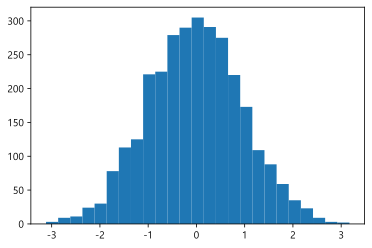

In [44]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)
plt.hist(X_org.ravel(), bins=25)

In [45]:
X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)
np.bincount(X[:, 0])

array([28, 38, 68, 48, 61, 59, 45, 56, 37, 40, 35, 34, 36, 26, 23, 26, 27,
       21, 23, 23, 18, 21, 10,  9, 17,  9,  7, 14, 12,  7,  3,  8,  4,  5,
        5,  3,  4,  2,  4,  1,  1,  3,  2,  5,  3,  8,  2,  5,  2,  1,  2,
        3,  3,  2,  2,  3,  3,  0,  1,  2,  1,  0,  0,  3,  1,  0,  0,  0,
        1,  3,  0,  1,  0,  2,  0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  2,
        2,  0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1], dtype=int64)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [47]:
ridge = Ridge(alpha=0.01).fit(X_train, y_train)
ridge.score(X_train, y_train), ridge.score(X_test, y_test)

(0.6562611944592338, 0.6224176353600326)

In [48]:
# 데이터에 0이 있으면 log 함수 적용 불가 → log(X + 1) 활용
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

In [49]:
ridge = Ridge(alpha=1).fit(X_train_log, y_train)
ridge.score(X_train_log, y_train), ridge.score(X_test_log, y_test)

(0.8627504186195984, 0.8749342372887816)

(array([19.,  0.,  0., 31.,  0., 56.,  0., 37., 41., 44., 67., 29., 82.,
        50., 60., 65., 48., 32., 23., 21., 19.,  7.,  7.,  8.,  4.]),
 array([0.        , 0.19183162, 0.38366324, 0.57549487, 0.76732649,
        0.95915811, 1.15098973, 1.34282135, 1.53465297, 1.7264846 ,
        1.91831622, 2.11014784, 2.30197946, 2.49381108, 2.68564271,
        2.87747433, 3.06930595, 3.26113757, 3.45296919, 3.64480081,
        3.83663244, 4.02846406, 4.22029568, 4.4121273 , 4.60395892,
        4.79579055]),
 <BarContainer object of 25 artists>)

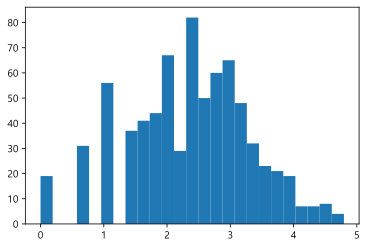

In [50]:
plt.hist(X_train_log[:, 0], bins=25)

In [57]:
cancer = load_breast_cancer()

In [58]:
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer['data']), 50))
X_noise = np.hstack([cancer['data'], noise])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_noise, cancer['target'], test_size=0.5, random_state=0)

In [69]:
select = SelectPercentile(score_func=f_classif, percentile=50).fit(X_train, y_train)
X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)

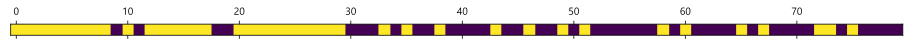

In [68]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))
plt.yticks(())
plt.show()

In [70]:
logreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)
logreg2 = LogisticRegression(max_iter=5000).fit(X_train_sel, y_train)
logreg.score(X_test, y_test), logreg2.score(X_test_sel, y_test)

(0.9508771929824561, 0.9333333333333333)

In [72]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0), threshold='median').fit(X_train, y_train)
X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)

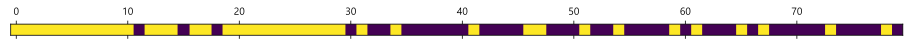

In [73]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))
plt.yticks(())
plt.show()

In [74]:
logreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)
logreg2 = LogisticRegression(max_iter=5000).fit(X_train_sel, y_train)
logreg.score(X_test, y_test), logreg2.score(X_test_sel, y_test)

(0.9508771929824561, 0.9508771929824561)

In [85]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=0), n_features_to_select=40).fit(X_train, y_train)
X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)

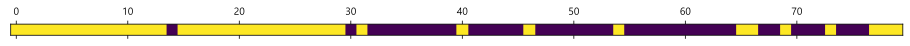

In [86]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))
plt.yticks(())
plt.show()

In [87]:
logreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)
logreg2 = LogisticRegression(max_iter=5000).fit(X_train_sel, y_train)
logreg.score(X_test, y_test), logreg2.score(X_test_sel, y_test)

(0.9508771929824561, 0.9508771929824561)

In [90]:
citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

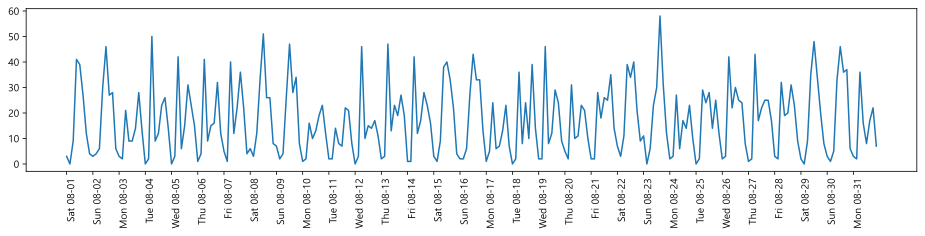

In [102]:
plt.figure(figsize=(16, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
xticks_name = [week[int(w)] + d for w, d in zip(xticks.strftime('%w'), xticks.strftime(' %m-%d'))]
plt.plot(citibike)
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.show()

In [109]:
X = citibike.index.astype('int64').values.reshape(-1, 1) // (10 ** 9)
y = citibike.values

In [110]:
n_train = 184

In [144]:
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]

    regressor.fit(X_train, y_train)
    print(f'테스트 세트 R^2: {regressor.score(X_test, y_test):.2f}')
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    plt.figure(figsize=(16, 3))
    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha='left')

    plt.plot(range(n_train), y_train, label='훈련')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='테스트')
    plt.plot(range(n_train), y_pred_train, '--', label='훈련 예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='테스트 예측')
    plt.legend(loc=(1.01, 0))

테스트 세트 R^2: -0.04


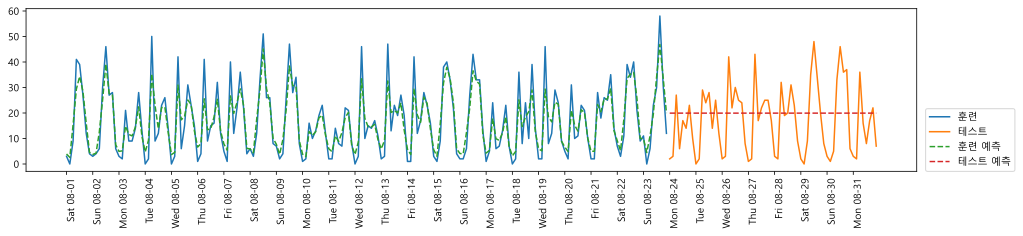

In [145]:
# RandomForest는 트리모델로, 훈련 세트에 있는 특성의 범위 밖으로 extrapolation 불가능
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

In [150]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_week = citibike.index.dayofweek.values.reshape(-1, 1)
X_hour_week = np.hstack([X_hour, X_week])
X_hour_week_onehot = OneHotEncoder().fit_transform(X_hour_week)
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_poly = poly_transformer.fit_transform(X_hour_week_onehot)

테스트 세트 R^2: 0.84


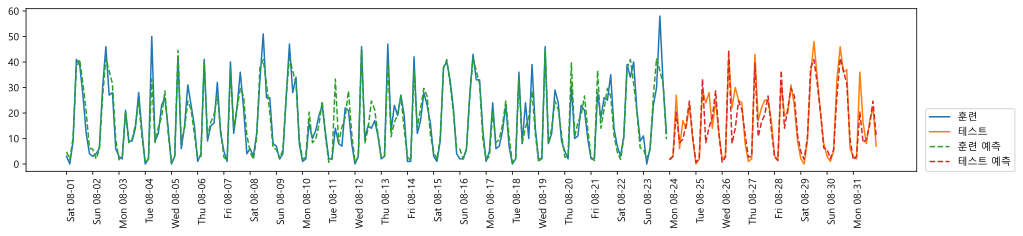

In [151]:
regressor = Ridge(alpha=0.01)
eval_on_features(X_hour_week_poly, y, regressor)

In [152]:
poly_transformer.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4',
       'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11',
       'x0 x12', 'x0 x13', 'x0 x14', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5',
       'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12',
       'x1 x13', 'x1 x14', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7',
       'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14',
       'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10',
       'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x4 x5', 'x4 x6', 'x4 x7',
       'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14',
       'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12',
       'x5 x13', 'x5 x14', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11',
       'x6 x12', 'x6 x13', 'x6 x14', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11',
       'x7 x12', 'x7 x13', 'x7 x14', 'x8 x9', 'x

In [153]:
hour = ['%02d:00' % i for i in range(0, 24, 3)]
day = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
feature = hour + day
poly_transformer.get_feature_names_out(feature)

array(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00',
       '21:00', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       '00:00 03:00', '00:00 06:00', '00:00 09:00', '00:00 12:00',
       '00:00 15:00', '00:00 18:00', '00:00 21:00', '00:00 Sun',
       '00:00 Mon', '00:00 Tue', '00:00 Wed', '00:00 Thu', '00:00 Fri',
       '00:00 Sat', '03:00 06:00', '03:00 09:00', '03:00 12:00',
       '03:00 15:00', '03:00 18:00', '03:00 21:00', '03:00 Sun',
       '03:00 Mon', '03:00 Tue', '03:00 Wed', '03:00 Thu', '03:00 Fri',
       '03:00 Sat', '06:00 09:00', '06:00 12:00', '06:00 15:00',
       '06:00 18:00', '06:00 21:00', '06:00 Sun', '06:00 Mon',
       '06:00 Tue', '06:00 Wed', '06:00 Thu', '06:00 Fri', '06:00 Sat',
       '09:00 12:00', '09:00 15:00', '09:00 18:00', '09:00 21:00',
       '09:00 Sun', '09:00 Mon', '09:00 Tue', '09:00 Wed', '09:00 Thu',
       '09:00 Fri', '09:00 Sat', '12:00 15:00', '12:00 18:00',
       '12:00 21:00', '12:00 Sun', '12:00 Mon', '12:00 Tu

In [154]:
features_poly = poly_transformer.get_feature_names_out(feature)
features_nonzero = np.array(features_poly)[regressor.coef_ != 0]
coef_nonzero = regressor.coef_[regressor.coef_ != 0]

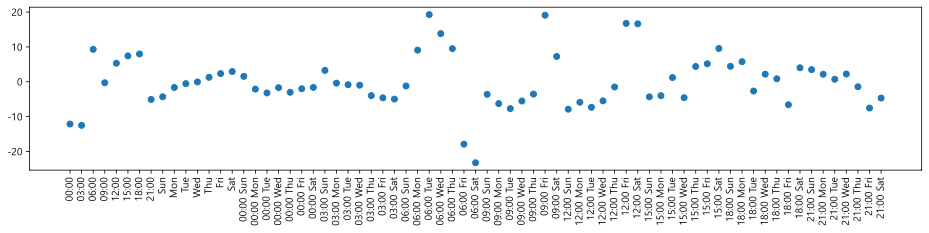

In [155]:
plt.figure(figsize=(16, 3))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.show()

In [168]:
citibike.between_time('04:00', '10:00').values[::2], citibike.between_time('04:00', '10:00').values[1::2]

(array([ 9,  6, 21, 50, 42, 41, 40, 12,  4, 16, 14, 46, 47, 42,  9,  6, 24,
        36, 46, 31, 28, 11,  6, 27, 29, 42, 43, 32,  9,  5, 36],
       dtype=int64),
 array([41, 30,  9,  9,  6,  9, 12, 33, 26, 10,  8, 10, 13, 12, 38, 27,  6,
         8,  8, 10, 18, 39, 23,  6, 24, 22, 17, 19, 35, 33, 16],
       dtype=int64))